In [1]:
from pandas import Series, DataFrame
import pandas as pd
import calendar
import statsmodels.api as sm
from patsy import dmatrices
%pylab inline

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


# Setup

In [2]:
#read data in, appended 2014/2015, removed GO from col names
crime2014 = pd.read_csv("https://raw.githubusercontent.com/sxzhu/mis381_project/master/data/Austin_Crime_2014.csv", dtype=unicode, encoding='utf-8')
crime2014[:3]

crime2015 = pd.read_csv("https://raw.githubusercontent.com/sxzhu/mis381_project/master/data/Austin_Crime_2015.csv", dtype=unicode, encoding='utf-8')
crime = crime2014.append(crime2015,ignore_index=True)

crime = crime.rename(index=str, columns={"Highest NIBRS/UCR Offense Description": "General Offense Description",\
                                 "GO Highest Offense Desc":"Detailed Offense Description",\
                                 "GO Location":"Location","GO Report Date":"Report Date",\
                                 "GO Location Zip":"Zipcode","GO District":"District","GO Census Tract":"Census Tract",\
                                 "GO X Coordinate":"X Coordinate","GO Y Coordinate":"Y Coordinate",\
                                      "GO Primary Key":"Primary Key"})

crime = crime.drop('Location_1', axis=1)
crime['Date'] = pd.DatetimeIndex(crime['Report Date'])
crime['Month'] = pd.DatetimeIndex(crime['Date']).month
crime['Month'] = crime['Month'].apply(lambda x: calendar.month_abbr[x])
crime['Year'] = pd.DatetimeIndex(crime['Report Date']).year

## Merge Crimes

In [3]:
def merge_crimes(s):
    """Map some crimes together."""
    
    # Create a map of misspellings to correct spelling
    misspellings = {'Burglary / \nBreaking & Entering':'Burglary',
                    'Auto Theft':'Theft: Auto Parts',
                    'Homicide: Murder & Nonnegligent Manslaughter':'Murder',
                    'Agg Assault':'Aggravated Assault'}
    
    if s in misspellings:
        return misspellings[s]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_crimes)

def merge_theft(s):
    """Map some crimes together."""
    
    if (s[:5]=='Theft'):
        return s[:5]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_theft)

# Check that it worked
# mask = (crime['General Offense Description'] == 'Agg Assault')
# crime['General Offense Description'][mask]  # should be empty

crime['General Offense Description'].value_counts()

Theft                 61908
Burglary              10597
Aggravated Assault     3803
Robbery                1809
Rape                   1042
Murder                   55
Name: General Offense Description, dtype: int64

In [4]:
crime[crime['Zipcode']=='78701']['General Offense Description'].value_counts()

Theft                 3566
Aggravated Assault     189
Burglary               162
Robbery                147
Rape                    73
Murder                   2
Name: General Offense Description, dtype: int64

# Final Dataframe

In [5]:
#Add the 'Streetname' column to both dataframes, keeping only the street name information
# removes leading numbers, leading 'BLOCK', leading hyphenated or / numbers, trailing 'NB', 'SB', 'EB', 'WB', trailing 'SVRD', and leading 'N', 'S', 'E', 'W'

crime['Streetname'] = crime['Location'].str.rsplit('\n', -1).str[0].str.replace('^[/\s\d-]+/?\d*\s+', '').str.replace('^\d+[A-Z]\s+', '').str.replace('^BLOCK\s+', '').str.replace('\s[NSEW]B\s*$', '').str.replace('\sSVRD\s*$', '').str.replace('^\s*[NSEW]\s+', '').str.replace(' HALF ST', ' ST').str.rstrip()
crime['PrimaryStreet'] = crime['Streetname'].str.rsplit(' / ', -1).str[0]
crime['SecondaryStreet'] = crime['Streetname'].str.rsplit(' / ', -1).str[1]

In [6]:
crime['DayOfWeek'] = pd.DatetimeIndex(crime['Date']).weekday
crime['DayOfWeek'] = crime['DayOfWeek'].apply(lambda x: calendar.day_abbr[x])

In [7]:
crime.head()

,Clearance Date,Clearance Status,Council District,Census Tract,District,Detailed Offense Description,Location,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,General Offense Description,Date,Month,Year,Streetname,PrimaryStreet,SecondaryStreet,DayOfWeek
0,04/28/2014 12:00:00 AM,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,12151 N IH 35 SVRD NB ...,78753,20141061920,04/17/2014 12:00:00 AM,3135985,10117220,Robbery,2014-04-17,Apr,2014,IH 35,IH 35,NaN,Thu
1,05/20/2014 12:00:00 AM,N,1,21.13,I,ROBBERY BY ASSAULT,3300 BLOCK ROCKHURST LN ...,78723,20141150937,04/25/2014 12:00:00 AM,3137985,10087946,Robbery,2014-04-25,Apr,2014,ROCKHURST LN,ROCKHURST LN,NaN,Fri
2,05/13/2014 12:00:00 AM,N,3,9.02,C,ROBBERY BY THREAT,E 7TH ST / CHICON ST ...,78702,20141310316,05/11/2014 12:00:00 AM,3120890,10068910,Robbery,2014-05-11,May,2014,7TH ST / CHICON ST,7TH ST,CHICON ST,Sun
3,03/24/2015 12:00:00 AM,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,WHELESS LN / BERKMAN DR ...,78723,20141670098,06/16/2014 12:00:00 AM,3130566,10089446,Robbery,2014-06-16,Jun,2014,WHELESS LN / BERKMAN DR,WHELESS LN,BERKMAN DR,Mon
4,10/02/2014 12:00:00 AM,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,WALLER ST / E 2ND ST ...,78702,20142070292,07/26/2014 12:00:00 AM,3117732,10068195,Robbery,2014-07-26,Jul,2014,WALLER ST / E 2ND ST,WALLER ST,E 2ND ST,Sat


In [12]:
df = crime[crime['Zipcode']=='78753']
df = df[df['Month']=='May']
result = pd.crosstab(df['DayOfWeek'], [df['Month'], df['Zipcode'], df['General Offense Description']], dropna=False)
result

Month                                      May                            
Zipcode                                  78753                            
General Offense Description Aggravated Assault Burglary Rape Robbery Theft
DayOfWeek                                                                 
Fri                                          2       15    2       2    85
Mon                                          4       12    1       2    85
Sat                                         10        8    1       4    93
Sun                                          5       10    0       5    45
Thu                                          7       22    3       1    69
Tue                                          5       17    0       0    57
Wed                                          6       20    0       1    86

In [9]:
df = crime.drop_duplicates(subset='Date')
test = pd.crosstab(df['DayOfWeek'], [df['Month']], dropna=False)
test

Month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
DayOfWeek,,,,,,,,,,,,
Fri,8,9,8,8,10,9,8,8,10,8,10,8
Mon,8,9,9,8,8,8,10,10,8,9,8,9
Sat,8,10,8,8,9,8,8,9,10,9,9,8
Sun,8,10,8,8,8,8,9,10,9,10,8,8
Thu,9,8,9,8,10,10,8,8,9,8,10,8
Tue,9,8,10,8,8,9,9,9,8,8,8,10
Wed,10,8,10,8,9,10,8,8,8,8,9,9


In [16]:
final = pd.DataFrame((result/test))
final.head()

Month                                      May                                \
Zipcode                                  78753                                 
General Offense Description Aggravated Assault  Burglary      Rape   Robbery   
DayOfWeek                                                                      
Fri                                   0.200000  1.500000  0.200000  0.200000   
Mon                                   0.500000  1.500000  0.125000  0.250000   
Sat                                   1.000000  0.800000  0.100000  0.400000   
Sun                                   0.555556  1.111111  0.000000  0.555556   
Thu                                   0.777778  2.444444  0.333333  0.111111   

Month                                   
Zipcode                                 
General Offense Description      Theft  
DayOfWeek                               
Fri                           8.500000  
Mon                          10.625000  
Sat                           9.300000  
Sun                           5.000000  
Thu                           7.666667

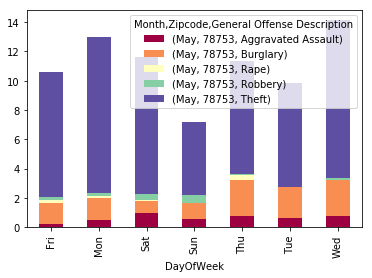

In [21]:
final.plot(kind='bar', stacked=True, colormap='Spectral')

In [11]:
final.columns = ['Month', 'Zipcode', 'General Offense Description', 'Day', 'Average']
one = final[final['Zipcode']=='78753']
two = one[one['Month']=='May']
two.sort_values('Day')

,Month,Zipcode,General Offense Description,Day,Average
17892,May,78753,Aggravated Assault,Fri,0.200000
17920,May,78753,Robbery,Fri,0.200000
17913,May,78753,Rape,Fri,0.200000
17906,May,78753,Murder,Fri,0.000000
17899,May,78753,Burglary,Fri,1.500000
17927,May,78753,Theft,Fri,8.500000
17907,May,78753,Murder,Mon,0.000000
17914,May,78753,Rape,Mon,0.125000
17900,May,78753,Burglary,Mon,1.500000
17893,May,78753,Aggravated Assault,Mon,0.500000


In [ ]:
result

In [ ]:
final2 = pd.DataFrame((result/test))
final2.plot(kind='bar', stacked=True)

In [ ]:
final2 = final2[final2['Zipcode']=='78753'].set_index('General Offense Description')
final2 = final2[final2['Month']=='May']
final2.set_index('DayOfWeek', inplace=True)
final2

In [ ]:
final3 = pd.DataFrame(final2.stack())
final2.plot(kind='bar', stacked=True)